In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, plot_histogram_and_save
from tools.ae_v2 import Autoencoder
from tools.GRU_AR_v1 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-07-09 22:28:14.039169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.039688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.104117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.104480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.104748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.107136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 22:28:14.107908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.108234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:28:14.108548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_004'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_rnn/rnn_004
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

# Autoencoder

In [14]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [16]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        5, 
        10,
        15,
        20,
        # 70,
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [17]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-3, 5e-4, 1e-4],
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
        # [5e-7],
    ]
    epochs = [
        [200]*len(learning_rate_list[0]),
        [200]*len(learning_rate_list[1]),
        [200]*len(learning_rate_list[2]),
        [200]*len(learning_rate_list[3]),
        # [1000],
    ]
    patience = [
        [20]*len(learning_rate_list[0]),
        [20]*len(learning_rate_list[1]),
        [20]*len(learning_rate_list[2]),
        [20]*len(learning_rate_list[3]),
        # [50],
    ] # parameter for early stopping
    min_delta = 5e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-4  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = [
        32,
        32,
        32,
        32,
        # 32,
    ]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
82/82 [==============================] - 7s 18ms/step - loss: 0.0881 - mse: 0.0103 - NMSE: 0.0936 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 9.3642E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
656/656 [==============================] - ETA: 0s - loss: 0.1544 - mse: 0.0180 - NMSE: 0.1630 - covmat_fro_loss: 3.6120e-04 - global_gradnorm: 24.9901 - tot_time: 0h 0m 44.2s

Epoch 1: val_NMSE did not improve from 0.09364
 - saving loss histories at /home/rkaushik/Docum

Epoch 12/200
656/656 [==============================] - ETA: 0s - loss: 0.0654 - mse: 0.0075 - NMSE: 0.0682 - covmat_fro_loss: 2.3437e-04 - global_gradnorm: 5.5863 - tot_time: 0h 5m 40.1s

Epoch 12: val_NMSE did not improve from 0.03601
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 40ms/step - loss: 0.0654 - mse: 0.0075 - NMSE: 0.0682 - covmat_fro_loss: 2.3448e-04 - global_gradnorm: 5.5816 - val_loss: 0.0546 - val_mse: 0.0063 - val_NMSE: 0.0566 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
656/656 [==============================] - ETA: 0s - loss: 0.0681 - mse: 0.0078 - NMSE: 0.0710 - covmat_fro_loss: 2.4610e-04 - global_gradnorm: 5.9265 - tot_time: 0h 6m 6.7s

Epoch 13: val_NMSE did not improve from 0.03601
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_

655/656 [============================>.] - ETA: 0s - loss: 0.1247 - mse: 0.0143 - NMSE: 0.1293 - covmat_fro_loss: 3.5061e-04 - global_gradnorm: 5.5759Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 10m 57.9s

Epoch 24: val_NMSE did not improve from 0.03601
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 41ms/step - loss: 0.1251 - mse: 0.0143 - NMSE: 0.1297 - covmat_fro_loss: 3.5173e-04 - global_gradnorm: 5.5733 - val_loss: 0.2588 - val_mse: 0.0298 - val_NMSE: 0.2697 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0005 ----------------------------

--------------------------------------------------------------------------------


Epoch 1

656/656 [==============================] - ETA: 0s - loss: 0.0378 - mse: 0.0043 - NMSE: 0.0394 - covmat_fro_loss: 1.6527e-04 - global_gradnorm: 5.6579 - tot_time: 0h 15m 50.9s

Epoch 11: val_NMSE improved from 0.01753 to 0.01299, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 41ms/step - loss: 0.0378 - mse: 0.0043 - NMSE: 0.0394 - covmat_fro_loss: 1.6525e-04 - global_gradnorm: 5.6661 - val_loss: 0.0130 - val_mse: 0.0014 - val_NMSE: 0.0130 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
656/656 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0036 - NMSE: 0.0324 - covmat_fro_loss: 1.5546e-04 - global_gradnorm: 5.6247 - tot_time: 0h 16m 17.5s

Epoch 12: val_NM

Epoch 23/200
656/656 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0023 - NMSE: 0.0205 - covmat_fro_loss: 1.3351e-04 - global_gradnorm: 3.6219 - tot_time: 0h 21m 8.1s

Epoch 23: val_NMSE did not improve from 0.01299
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 39ms/step - loss: 0.0202 - mse: 0.0023 - NMSE: 0.0205 - covmat_fro_loss: 1.3345e-04 - global_gradnorm: 3.6183 - val_loss: 0.0177 - val_mse: 0.0020 - val_NMSE: 0.0179 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
655/656 [============================>.] - ETA: 0s - loss: 0.0241 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 1.4322e-04 - global_gradnorm: 3.9989 - tot_time: 0h 21m 34.6s

Epoch 24: val_NMSE did not improve from 0.01299
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERN

Epoch 35/200
656/656 [==============================] - ETA: 0s - loss: 0.0363 - mse: 0.0041 - NMSE: 0.0371 - covmat_fro_loss: 1.7537e-04 - global_gradnorm: 3.5074 - tot_time: 0h 26m 22.8s

Epoch 35: val_NMSE did not improve from 0.01164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 40ms/step - loss: 0.0363 - mse: 0.0041 - NMSE: 0.0371 - covmat_fro_loss: 1.7539e-04 - global_gradnorm: 3.5062 - val_loss: 0.0288 - val_mse: 0.0032 - val_NMSE: 0.0293 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/200
655/656 [============================>.] - ETA: 0s - loss: 0.0243 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 1.4789e-04 - global_gradnorm: 2.8204 - tot_time: 0h 26m 48.6s

Epoch 36: val_NMSE did not improve from 0.01164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AER

656/656 [==============================] - ETA: 0s - loss: 0.0371 - mse: 0.0042 - NMSE: 0.0377 - covmat_fro_loss: 1.7353e-04 - global_gradnorm: 3.3687 - tot_time: 0h 31m 37.0s

Epoch 47: val_NMSE did not improve from 0.01164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 40ms/step - loss: 0.0371 - mse: 0.0042 - NMSE: 0.0377 - covmat_fro_loss: 1.7349e-04 - global_gradnorm: 3.3695 - val_loss: 0.0304 - val_mse: 0.0034 - val_NMSE: 0.0307 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/200
656/656 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 1.5439e-04 - global_gradnorm: 3.0272 - tot_time: 0h 32m 2.5s

Epoch 48: val_NMSE did not improve from 0.01164
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_

Epoch 8/200
656/656 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.9432e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.5033e-05 - global_gradnorm: 1.6642 - tot_time: 0h 36m 20.6s

Epoch 8: val_NMSE improved from 0.00596 to 0.00523, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 40ms/step - loss: 0.0061 - mse: 5.9432e-04 - NMSE: 0.0054 - covmat_fro_loss: 6.5019e-05 - global_gradnorm: 1.6622 - val_loss: 0.0059 - val_mse: 5.7770e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 9/200
655/656 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7928e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.3198e-05 - global_gradnorm: 1.7094 - tot_time: 0h 3

Epoch 20/200
656/656 [==============================] - ETA: 0s - loss: 0.0049 - mse: 4.6149e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.4147e-05 - global_gradnorm: 1.3739 - tot_time: 0h 41m 32.0s

Epoch 20: val_NMSE improved from 0.00448 to 0.00421, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 39ms/step - loss: 0.0049 - mse: 4.6149e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.4147e-05 - global_gradnorm: 1.3731 - val_loss: 0.0050 - val_mse: 4.6513e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 21/200
655/656 [============================>.] - ETA: 0s - loss: 0.0059 - mse: 5.7133e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.8470e-05 - global_gradnorm: 1.7860 - tot_time: 0

Epoch 32/200
655/656 [============================>.] - ETA: 0s - loss: 0.0068 - mse: 6.7545e-04 - NMSE: 0.0061 - covmat_fro_loss: 6.2980e-05 - global_gradnorm: 1.9120 - tot_time: 0h 46m 46.5s

Epoch 32: val_NMSE did not improve from 0.00421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 40ms/step - loss: 0.0068 - mse: 6.7526e-04 - NMSE: 0.0061 - covmat_fro_loss: 6.2999e-05 - global_gradnorm: 1.9096 - val_loss: 0.0088 - val_mse: 9.0331e-04 - val_NMSE: 0.0082 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 33/200
656/656 [==============================] - ETA: 0s - loss: 0.0051 - mse: 4.8097e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.6080e-05 - global_gradnorm: 1.4868 - tot_time: 0h 47m 13.1s

Epoch 33: val_NMSE improved from 0.00421 to 0.00352, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/sav

Epoch 44/200
655/656 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 3.7678e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.9619e-05 - global_gradnorm: 1.3710 - tot_time: 0h 52m 0.6s

Epoch 44: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 40ms/step - loss: 0.0042 - mse: 3.7705e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.9666e-05 - global_gradnorm: 1.3687 - val_loss: 0.0058 - val_mse: 5.5920e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/200
655/656 [============================>.] - ETA: 0s - loss: 0.0049 - mse: 4.5664e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.3104e-05 - global_gradnorm: 1.5093 - tot_time: 0h 52m 27.3s

Epoch 45: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lore

Epoch 56/200
655/656 [============================>.] - ETA: 0s - loss: 0.0057 - mse: 5.4834e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.9997e-05 - global_gradnorm: 1.9115 - tot_time: 0h 57m 16.1s

Epoch 56: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 41ms/step - loss: 0.0057 - mse: 5.4784e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.9934e-05 - global_gradnorm: 1.9096 - val_loss: 0.0050 - val_mse: 4.6232e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 57/200
656/656 [==============================] - ETA: 0s - loss: 0.0049 - mse: 4.4957e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.1045e-05 - global_gradnorm: 1.3941 - tot_time: 0h 57m 43.4s

Epoch 57: val_NMSE did not improve from 0.00302
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lor

Epoch 68/200
656/656 [==============================] - ETA: 0s - loss: 0.0044 - mse: 3.9475e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.0885e-05 - global_gradnorm: 1.2640 - tot_time: 1h 2m 30.5s

Epoch 68: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 27s 40ms/step - loss: 0.0044 - mse: 3.9475e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.0905e-05 - global_gradnorm: 1.2658 - val_loss: 0.0097 - val_mse: 0.0010 - val_NMSE: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 69/200
656/656 [==============================] - ETA: 0s - loss: 0.0060 - mse: 5.7367e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.1861e-05 - global_gradnorm: 1.7450 - tot_time: 1h 2m 56.5s

Epoch 69: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/sa

655/656 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 5.1840e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.7977e-05 - global_gradnorm: 1.5258Restoring model weights from the end of the best epoch: 60.
 - tot_time: 1h 7m 46.9s

Epoch 80: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 26s 40ms/step - loss: 0.0055 - mse: 5.1820e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.7964e-05 - global_gradnorm: 1.5226 - val_loss: 0.0049 - val_mse: 4.5419e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 80: early stopping


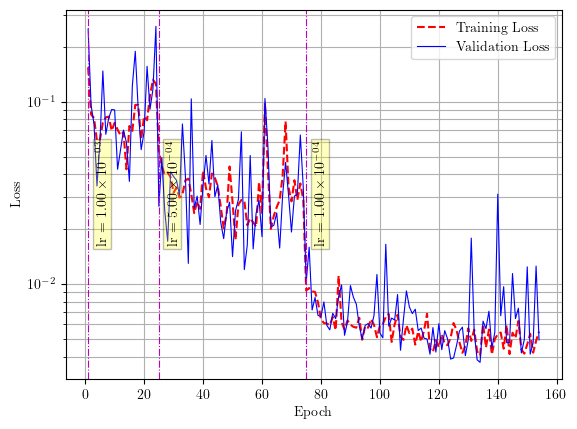

<Figure size 640x480 with 0 Axes>

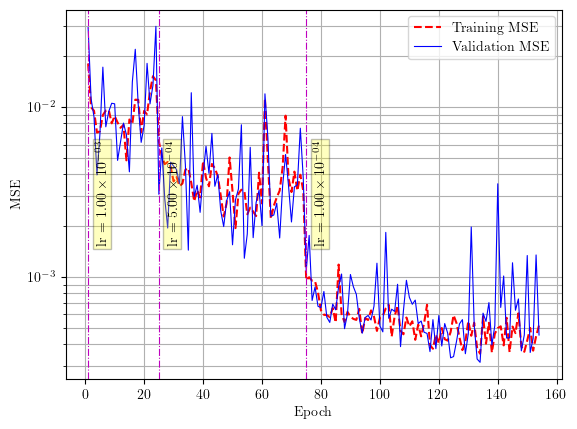

<Figure size 640x480 with 0 Axes>

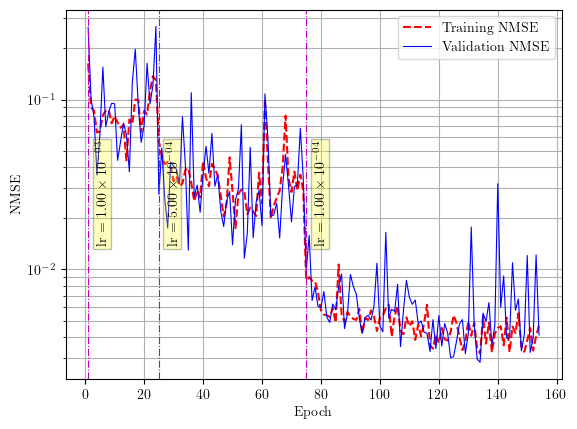

<Figure size 640x480 with 0 Axes>

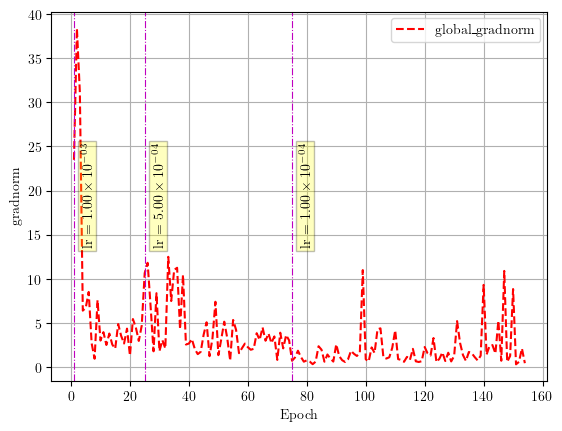



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 38.400000000000006
62/62 [==============================] - 10s 24ms/step - loss: 0.0305 - mse: 0.0038 - NMSE: 0.0345 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 3.4508E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.0744 - mse: 0.0094 - NMSE: 0.0848 - covmat_fro_loss: 2.2643e-04 - global_gradnorm: 25.7119 - tot_time: 0h 0m 58.5s

Epoch 1: val_NMSE did not improve from 0.03451
 - saving loss histories at /home

Epoch 12/200
500/500 [==============================] - ETA: 0s - loss: 0.0526 - mse: 0.0065 - NMSE: 0.0591 - covmat_fro_loss: 2.4077e-04 - global_gradnorm: 17.3886 - tot_time: 0h 7m 4.9s

Epoch 12: val_NMSE did not improve from 0.03288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0526 - mse: 0.0065 - NMSE: 0.0591 - covmat_fro_loss: 2.4075e-04 - global_gradnorm: 17.3943 - val_loss: 0.0622 - val_mse: 0.0077 - val_NMSE: 0.0700 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
500/500 [==============================] - ETA: 0s - loss: 0.0566 - mse: 0.0070 - NMSE: 0.0635 - covmat_fro_loss: 2.5681e-04 - global_gradnorm: 17.9412 - tot_time: 0h 7m 37.9s

Epoch 13: val_NMSE did not improve from 0.03288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

500/500 [==============================] - ETA: 0s - loss: 0.0446 - mse: 0.0055 - NMSE: 0.0497 - covmat_fro_loss: 2.2650e-04 - global_gradnorm: 15.6450 - tot_time: 0h 13m 41.1s

Epoch 24: val_NMSE did not improve from 0.03288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 67ms/step - loss: 0.0446 - mse: 0.0055 - NMSE: 0.0497 - covmat_fro_loss: 2.2650e-04 - global_gradnorm: 15.6493 - val_loss: 0.0579 - val_mse: 0.0072 - val_NMSE: 0.0653 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.0522 - mse: 0.0064 - NMSE: 0.0584 - covmat_fro_loss: 2.4537e-04 - global_gradnorm: 16.4525 - tot_time: 0h 14m 13.9s

Epoch 25: val_NMSE did not improve from 0.03288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

Epoch 36/200
500/500 [==============================] - ETA: 0s - loss: 0.0390 - mse: 0.0048 - NMSE: 0.0433 - covmat_fro_loss: 2.1531e-04 - global_gradnorm: 12.7415 - tot_time: 0h 20m 18.2s

Epoch 36: val_NMSE improved from 0.02984 to 0.02925, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0390 - mse: 0.0048 - NMSE: 0.0433 - covmat_fro_loss: 2.1531e-04 - global_gradnorm: 12.7928 - val_loss: 0.0268 - val_mse: 0.0032 - val_NMSE: 0.0292 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/200
500/500 [==============================] - ETA: 0s - loss: 0.0398 - mse: 0.0049 - NMSE: 0.0441 - covmat_fro_loss: 2.1779e-04 - global_gradnorm: 14.0169 - tot_time: 0h 20m 50.8s

Epoch 48/200
500/500 [==============================] - ETA: 0s - loss: 0.0382 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 2.0706e-04 - global_gradnorm: 11.4272 - tot_time: 0h 26m 53.6s

Epoch 48: val_NMSE did not improve from 0.02864
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 65ms/step - loss: 0.0382 - mse: 0.0047 - NMSE: 0.0424 - covmat_fro_loss: 2.0708e-04 - global_gradnorm: 11.4279 - val_loss: 0.0291 - val_mse: 0.0035 - val_NMSE: 0.0319 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/200
500/500 [==============================] - ETA: 0s - loss: 0.0382 - mse: 0.0047 - NMSE: 0.0423 - covmat_fro_loss: 2.0560e-04 - global_gradnorm: 12.4161 - tot_time: 0h 27m 26.4s

Epoch 49: val_NMSE did not improve from 0.02864
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

Epoch 60/200
500/500 [==============================] - ETA: 0s - loss: 0.0343 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 1.9989e-04 - global_gradnorm: 11.0933 - tot_time: 0h 33m 30.6s

Epoch 60: val_NMSE did not improve from 0.02588
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 67ms/step - loss: 0.0343 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 1.9987e-04 - global_gradnorm: 11.0839 - val_loss: 0.0304 - val_mse: 0.0037 - val_NMSE: 0.0332 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/200
500/500 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 1.8506e-04 - global_gradnorm: 9.5153 - tot_time: 0h 34m 3.0s

Epoch 61: val_NMSE improved from 0.02588 to 0.02324, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rn

Epoch 72/200
500/500 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0036 - NMSE: 0.0323 - covmat_fro_loss: 1.8234e-04 - global_gradnorm: 9.5744 - tot_time: 0h 40m 5.4s

Epoch 72: val_NMSE did not improve from 0.02324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 32s 64ms/step - loss: 0.0295 - mse: 0.0036 - NMSE: 0.0323 - covmat_fro_loss: 1.8251e-04 - global_gradnorm: 9.5971 - val_loss: 0.0301 - val_mse: 0.0036 - val_NMSE: 0.0328 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/200
500/500 [==============================] - ETA: 0s - loss: 0.0282 - mse: 0.0034 - NMSE: 0.0309 - covmat_fro_loss: 1.7631e-04 - global_gradnorm: 9.2420 - tot_time: 0h 40m 39.3s

Epoch 73: val_NMSE did not improve from 0.02324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AER

Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 1.5239e-04 - global_gradnorm: 9.3747 - tot_time: 0h 46m 41.0s

Epoch 3: val_NMSE did not improve from 0.01835
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 67ms/step - loss: 0.0208 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 1.5238e-04 - global_gradnorm: 9.3586 - val_loss: 0.0246 - val_mse: 0.0030 - val_NMSE: 0.0269 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 4/200
500/500 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 1.5316e-04 - global_gradnorm: 9.9324 - tot_time: 0h 47m 14.1s

Epoch 4: val_NMSE improved from 0.01835 to 0.01763, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_

Epoch 15/200
500/500 [==============================] - ETA: 0s - loss: 0.0197 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 1.4533e-04 - global_gradnorm: 10.1741 - tot_time: 0h 53m 18.4s

Epoch 15: val_NMSE did not improve from 0.01499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0197 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 1.4526e-04 - global_gradnorm: 10.1784 - val_loss: 0.0229 - val_mse: 0.0027 - val_NMSE: 0.0249 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
500/500 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 1.4260e-04 - global_gradnorm: 9.3082 - tot_time: 0h 53m 51.7s

Epoch 16: val_NMSE did not improve from 0.01499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_

500/500 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 1.4483e-04 - global_gradnorm: 9.9324 - tot_time: 0h 59m 59.1s

Epoch 27: val_NMSE did not improve from 0.01499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 34s 67ms/step - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 1.4483e-04 - global_gradnorm: 9.9891 - val_loss: 0.0193 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 28/200
500/500 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0231 - covmat_fro_loss: 1.4882e-04 - global_gradnorm: 10.2396 - tot_time: 1h 0m 31.4s

Epoch 28: val_NMSE did not improve from 0.01499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0112 - mse: 0.0012 - NMSE: 0.0113 - covmat_fro_loss: 1.1955e-04 - global_gradnorm: 6.7599 - val_loss: 0.0114 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 5/200
500/500 [==============================] - ETA: 0s - loss: 0.0110 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 1.1815e-04 - global_gradnorm: 6.9026 - tot_time: 1h 6m 38.3s

Epoch 5: val_NMSE did not improve from 0.01157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0110 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 1.1814e-04 - global_gradnorm: 6.8969 - val_loss: 0.011

Epoch 16/200
500/500 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 1.1118e-04 - global_gradnorm: 6.9983 - tot_time: 1h 12m 44.4s

Epoch 16: val_NMSE improved from 0.01079 to 0.01019, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 67ms/step - loss: 0.0105 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 1.1118e-04 - global_gradnorm: 6.9857 - val_loss: 0.0102 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 17/200
500/500 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 1.1175e-04 - global_gradnorm: 7.2810 - tot_time: 1h 13m 18.5s

E

Epoch 28/200
500/500 [==============================] - ETA: 0s - loss: 0.0097 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 1.0891e-04 - global_gradnorm: 7.3319 - tot_time: 1h 19m 23.3s

Epoch 28: val_NMSE did not improve from 0.01019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 34s 67ms/step - loss: 0.0097 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 1.0887e-04 - global_gradnorm: 7.3212 - val_loss: 0.0116 - val_mse: 0.0013 - val_NMSE: 0.0118 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 29/200
500/500 [==============================] - ETA: 0s - loss: 0.0102 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 1.0883e-04 - global_gradnorm: 7.5853 - tot_time: 1h 19m 56.3s

Epoch 29: val_NMSE did not improve from 0.01019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

Epoch 40/200
500/500 [==============================] - ETA: 0s - loss: 0.0104 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 1.0875e-04 - global_gradnorm: 8.2626 - tot_time: 1h 26m 0.8s

Epoch 40: val_NMSE did not improve from 0.00987
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 33s 66ms/step - loss: 0.0104 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 1.0874e-04 - global_gradnorm: 8.2566 - val_loss: 0.0128 - val_mse: 0.0015 - val_NMSE: 0.0132 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 41/200
500/500 [==============================] - ETA: 0s - loss: 0.0104 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 1.0842e-04 - global_gradnorm: 7.7112 - tot_time: 1h 26m 34.2s

Epoch 41: val_NMSE did not improve from 0.00987
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AER

Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.0106 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 1.0725e-04 - global_gradnorm: 7.7613 - tot_time: 1h 32m 39.0s

Epoch 52: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 34s 67ms/step - loss: 0.0106 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 1.0722e-04 - global_gradnorm: 7.7469 - val_loss: 0.0104 - val_mse: 0.0012 - val_NMSE: 0.0105 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 53/200
500/500 [==============================] - ETA: 0s - loss: 0.0096 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 1.0537e-04 - global_gradnorm: 7.5857 - tot_time: 1h 33m 12.2s

Epoch 53: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

500/500 [==============================] - ETA: 0s - loss: 0.0092 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 1.0408e-04 - global_gradnorm: 8.3655 - tot_time: 1h 39m 16.4s

Epoch 64: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 34s 67ms/step - loss: 0.0092 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 1.0406e-04 - global_gradnorm: 8.3532 - val_loss: 0.0117 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 65/200
500/500 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 1.0318e-04 - global_gradnorm: 8.7054Restoring model weights from the end of the best epoch: 45.
 - tot_time: 1h 39m 49.3s

Epoch 65: val_NMSE did not improve from 0.00916
 - saving loss histories at /home/rkaushi

<Figure size 640x480 with 0 Axes>

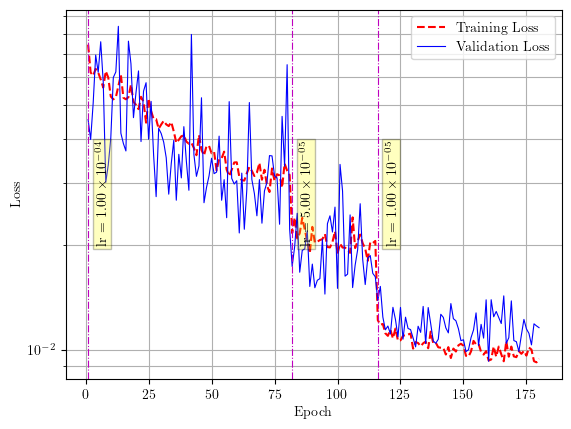

<Figure size 640x480 with 0 Axes>

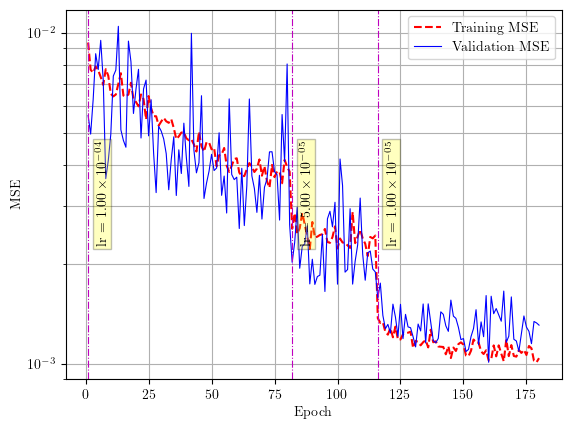

<Figure size 640x480 with 0 Axes>

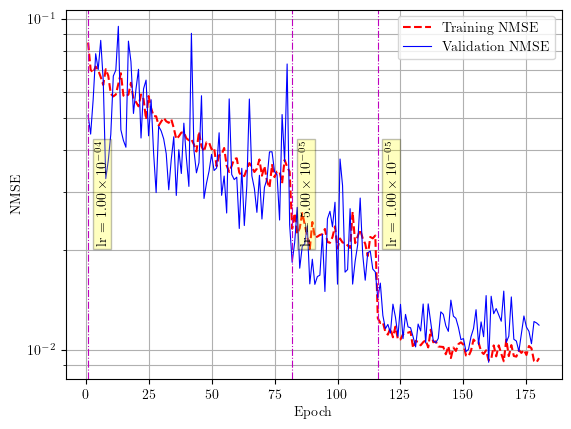

<Figure size 640x480 with 0 Axes>

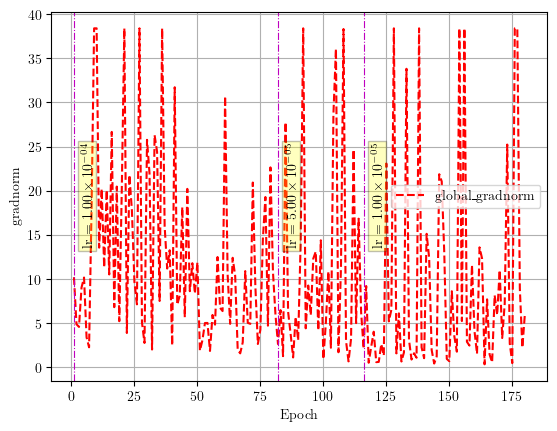



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 38.400000000000006
50/50 [==============================] - 14s 32ms/step - loss: 0.0326 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 3.9823E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
403/403 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0042 - NMSE: 0.0380 - covmat_fro_loss: 1.9120e-04 - global_gradnorm: 22.1262 - tot_time: 0h 1m 13.7s

Epoch 1: val_NMSE improved from 0.03982 to 0.03689, saving model to /home/rkaush

Epoch 11/200
403/403 [==============================] - ETA: 0s - loss: 0.0236 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 1.7403e-04 - global_gradnorm: 20.5796 - tot_time: 0h 7m 19.4s

Epoch 11: val_NMSE did not improve from 0.02807
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 38s 93ms/step - loss: 0.0236 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 1.7414e-04 - global_gradnorm: 20.6237 - val_loss: 0.0260 - val_mse: 0.0034 - val_NMSE: 0.0307 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
403/403 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.7910e-04 - global_gradnorm: 21.2036 - tot_time: 0h 7m 56.7s

Epoch 12: val_NMSE did not improve from 0.02807
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_A

Epoch 23/200
403/403 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 1.7157e-04 - global_gradnorm: 19.0496 - tot_time: 0h 14m 47.7s

Epoch 23: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 91ms/step - loss: 0.0208 - mse: 0.0027 - NMSE: 0.0242 - covmat_fro_loss: 1.7154e-04 - global_gradnorm: 19.0144 - val_loss: 0.0233 - val_mse: 0.0030 - val_NMSE: 0.0274 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
403/403 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 1.7177e-04 - global_gradnorm: 19.7327 - tot_time: 0h 15m 25.1s

Epoch 24: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

403/403 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0025 - NMSE: 0.0230 - covmat_fro_loss: 1.7082e-04 - global_gradnorm: 19.4102 - tot_time: 0h 22m 8.5s

Epoch 35: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 91ms/step - loss: 0.0199 - mse: 0.0025 - NMSE: 0.0230 - covmat_fro_loss: 1.7085e-04 - global_gradnorm: 19.4572 - val_loss: 0.0261 - val_mse: 0.0034 - val_NMSE: 0.0308 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/200
403/403 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 1.7267e-04 - global_gradnorm: 19.1897 - tot_time: 0h 22m 45.5s

Epoch 36: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_

Epoch 9/200
403/403 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 1.6348e-04 - global_gradnorm: 17.1923 - tot_time: 0h 29m 30.7s

Epoch 9: val_NMSE did not improve from 0.02063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 91ms/step - loss: 0.0179 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 1.6354e-04 - global_gradnorm: 17.2448 - val_loss: 0.0188 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 10/200
403/403 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 1.6665e-04 - global_gradnorm: 17.2572 - tot_time: 0h 30m 7.1s

Epoch 10: val_NMSE did not improve from 0.02063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

Epoch 21/200
403/403 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 1.6245e-04 - global_gradnorm: 17.7202 - tot_time: 0h 36m 52.9s

Epoch 21: val_NMSE did not improve from 0.01924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 91ms/step - loss: 0.0174 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 1.6253e-04 - global_gradnorm: 17.7344 - val_loss: 0.0197 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 22/200
403/403 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0023 - NMSE: 0.0205 - covmat_fro_loss: 1.6283e-04 - global_gradnorm: 17.8953 - tot_time: 0h 37m 30.4s

Epoch 22: val_NMSE did not improve from 0.01924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

403/403 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 1.6336e-04 - global_gradnorm: 16.6601 - tot_time: 0h 44m 17.0s

Epoch 33: val_NMSE did not improve from 0.01924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 91ms/step - loss: 0.0173 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 1.6335e-04 - global_gradnorm: 16.7140 - val_loss: 0.0209 - val_mse: 0.0027 - val_NMSE: 0.0241 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
403/403 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0022 - NMSE: 0.0199 - covmat_fro_loss: 1.6178e-04 - global_gradnorm: 17.9954 - tot_time: 0h 44m 54.4s

Epoch 34: val_NMSE did not improve from 0.01924
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 38s 93ms/step - loss: 0.0157 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 1.5749e-04 - global_gradnorm: 15.9571 - val_loss: 0.0170 - val_mse: 0.0021 - val_NMSE: 0.0193 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 10/200
403/403 [==============================] - ETA: 0s - loss: 0.0155 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 1.5746e-04 - global_gradnorm: 15.0205 - tot_time: 0h 51m 40.4s

Epoch 10: val_NMSE did not improve from 0.01805
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 38s 94ms/step - loss: 0.0155 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 1.5745e-04 - global_gradnorm: 14.9867 - val_loss:

Epoch 22/200
403/403 [==============================] - ETA: 0s - loss: 0.0155 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 1.5700e-04 - global_gradnorm: 15.3020 - tot_time: 0h 59m 3.5s

Epoch 22: val_NMSE did not improve from 0.01805
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 37s 92ms/step - loss: 0.0155 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 1.5701e-04 - global_gradnorm: 15.3592 - val_loss: 0.0167 - val_mse: 0.0021 - val_NMSE: 0.0190 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/200
403/403 [==============================] - ETA: 0s - loss: 0.0157 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 1.5727e-04 - global_gradnorm: 15.3611Restoring model weights from the end of the best epoch: 3.
 - tot_time: 0h 59m 40.7s

Epoch 23: val_NMSE did not improve from 0.01805
 - saving loss histories at

<Figure size 640x480 with 0 Axes>

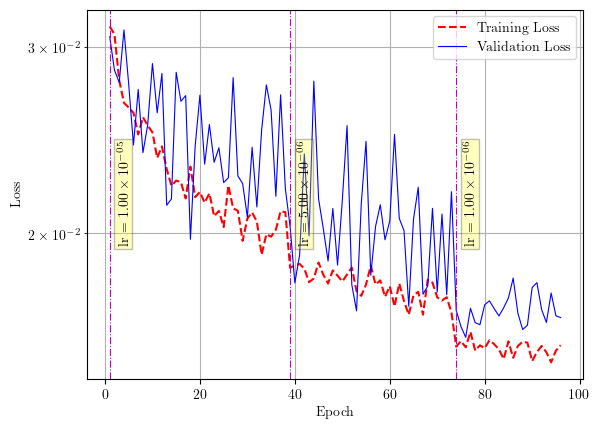

<Figure size 640x480 with 0 Axes>

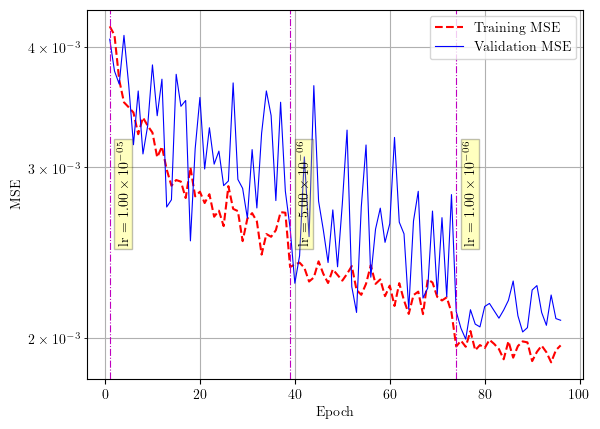

<Figure size 640x480 with 0 Axes>

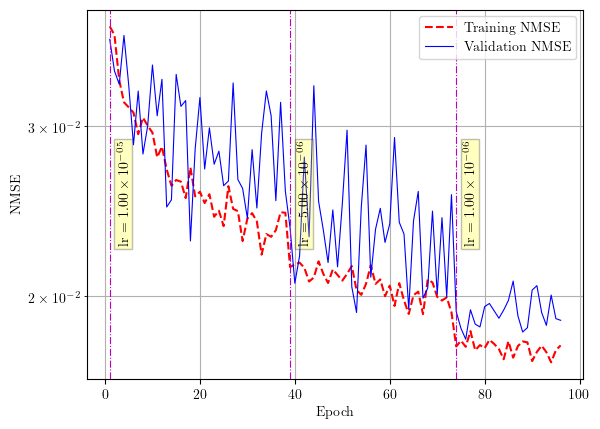

<Figure size 640x480 with 0 Axes>

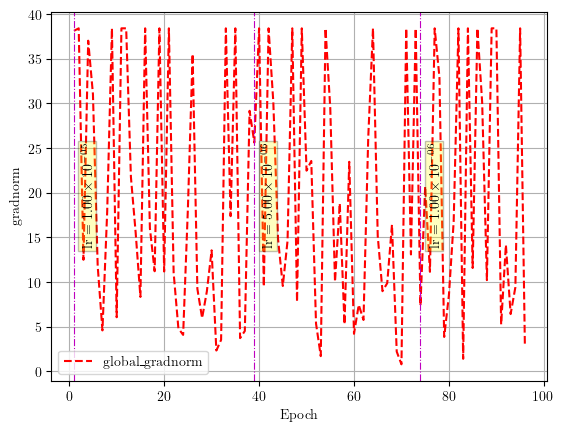



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 20 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 38.400000000000006
42/42 [==============================] - 19s 36ms/step - loss: 0.0400 - mse: 0.0059 - NMSE: 0.0532 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 5.3209E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
338/338 [==============================] - ETA: 0s - loss: 0.0380 - mse: 0.0055 - NMSE: 0.0500 - covmat_fro_loss: 2.2660e-04 - global_gradnorm: 28.3088 - tot_time: 0h 1m 31.3s

Epoch 1: val_NMSE did not improve from 0.05321
 - saving loss histories at /home

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 39s 116ms/step - loss: 0.0337 - mse: 0.0048 - NMSE: 0.0438 - covmat_fro_loss: 2.2767e-04 - global_gradnorm: 26.8255 - val_loss: 0.0381 - val_mse: 0.0055 - val_NMSE: 0.0500 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
338/338 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0048 - NMSE: 0.0433 - covmat_fro_loss: 2.2839e-04 - global_gradnorm: 26.1168 - tot_time: 0h 8m 47.5s

Epoch 12: val_NMSE improved from 0.04877 to 0.04795, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/checkpoint-20_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [=========================

Epoch 23/200
338/338 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 2.3287e-04 - global_gradnorm: 26.3362 - tot_time: 0h 16m 1.8s

Epoch 23: val_NMSE did not improve from 0.04595
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 39s 116ms/step - loss: 0.0314 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 2.3291e-04 - global_gradnorm: 26.2995 - val_loss: 0.0366 - val_mse: 0.0053 - val_NMSE: 0.0476 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
338/338 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0045 - NMSE: 0.0405 - covmat_fro_loss: 2.3208e-04 - global_gradnorm: 26.3990 - tot_time: 0h 16m 40.9s

Epoch 24: val_NMSE did not improve from 0.04595
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

Epoch 35/200
338/338 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 2.3876e-04 - global_gradnorm: 26.1828 - tot_time: 0h 23m 50.1s

Epoch 35: val_NMSE did not improve from 0.04459
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 38s 113ms/step - loss: 0.0309 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 2.3882e-04 - global_gradnorm: 26.1915 - val_loss: 0.0367 - val_mse: 0.0052 - val_NMSE: 0.0475 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/200
338/338 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0044 - NMSE: 0.0397 - covmat_fro_loss: 2.3689e-04 - global_gradnorm: 25.6357 - tot_time: 0h 24m 29.0s

Epoch 36: val_NMSE did not improve from 0.04459
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

Epoch 47/200
338/338 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0042 - NMSE: 0.0377 - covmat_fro_loss: 2.4235e-04 - global_gradnorm: 25.9218 - tot_time: 0h 31m 38.6s

Epoch 47: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 39s 116ms/step - loss: 0.0293 - mse: 0.0042 - NMSE: 0.0377 - covmat_fro_loss: 2.4239e-04 - global_gradnorm: 25.8801 - val_loss: 0.0361 - val_mse: 0.0052 - val_NMSE: 0.0469 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/200
338/338 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0042 - NMSE: 0.0385 - covmat_fro_loss: 2.4214e-04 - global_gradnorm: 25.8286 - tot_time: 0h 32m 17.1s

Epoch 48: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

338/338 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 2.3866e-04 - global_gradnorm: 26.2599 - tot_time: 0h 39m 27.5s

Epoch 59: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 38s 111ms/step - loss: 0.0298 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 2.3858e-04 - global_gradnorm: 26.2957 - val_loss: 0.0351 - val_mse: 0.0050 - val_NMSE: 0.0454 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/200
338/338 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 2.4024e-04 - global_gradnorm: 26.3464 - tot_time: 0h 40m 6.1s

Epoch 60: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

Epoch 6/200
338/338 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 2.4175e-04 - global_gradnorm: 26.2448 - tot_time: 0h 48m 10.7s

Epoch 6: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 40s 117ms/step - loss: 0.0295 - mse: 0.0042 - NMSE: 0.0379 - covmat_fro_loss: 2.4183e-04 - global_gradnorm: 26.2246 - val_loss: 0.0348 - val_mse: 0.0050 - val_NMSE: 0.0450 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 7/200
338/338 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 2.4102e-04 - global_gradnorm: 25.9491 - tot_time: 0h 48m 50.3s

Epoch 7: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

338/338 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0043 - NMSE: 0.0386 - covmat_fro_loss: 2.4030e-04 - global_gradnorm: 25.8645 - tot_time: 0h 55m 58.8s

Epoch 18: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 38s 114ms/step - loss: 0.0301 - mse: 0.0043 - NMSE: 0.0386 - covmat_fro_loss: 2.4040e-04 - global_gradnorm: 25.9015 - val_loss: 0.0345 - val_mse: 0.0049 - val_NMSE: 0.0446 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 19/200
338/338 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0042 - NMSE: 0.0378 - covmat_fro_loss: 2.4053e-04 - global_gradnorm: 25.7574 - tot_time: 0h 56m 38.2s

Epoch 19: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

Epoch 7/200
338/338 [==============================] - ETA: 0s - loss: 0.0297 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 2.4060e-04 - global_gradnorm: 25.5908 - tot_time: 1h 3m 50.3s

Epoch 7: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 39s 115ms/step - loss: 0.0297 - mse: 0.0042 - NMSE: 0.0382 - covmat_fro_loss: 2.4061e-04 - global_gradnorm: 25.6286 - val_loss: 0.0343 - val_mse: 0.0049 - val_NMSE: 0.0444 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 8/200
338/338 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0041 - NMSE: 0.0371 - covmat_fro_loss: 2.4072e-04 - global_gradnorm: 25.5387 - tot_time: 1h 4m 29.9s

Epoch 8: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERN

338/338 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 2.3955e-04 - global_gradnorm: 25.0362 - tot_time: 1h 11m 40.1s

Epoch 19: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 39s 116ms/step - loss: 0.0284 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 2.3957e-04 - global_gradnorm: 25.0756 - val_loss: 0.0344 - val_mse: 0.0049 - val_NMSE: 0.0444 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 20/200
338/338 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 2.3982e-04 - global_gradnorm: 25.3775 - tot_time: 1h 12m 19.1s

Epoch 20: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

338/338 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 2.3963e-04 - global_gradnorm: 25.5706 - tot_time: 1h 19m 32.7s

Epoch 31: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_004/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 38s 113ms/step - loss: 0.0291 - mse: 0.0041 - NMSE: 0.0373 - covmat_fro_loss: 2.3967e-04 - global_gradnorm: 25.6084 - val_loss: 0.0343 - val_mse: 0.0049 - val_NMSE: 0.0444 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 32/200
338/338 [==============================] - ETA: 0s - loss: 0.0292 - mse: 0.0041 - NMSE: 0.0375 - covmat_fro_loss: 2.3976e-04 - global_gradnorm: 25.9180 - tot_time: 1h 20m 12.8s

Epoch 32: val_NMSE did not improve from 0.04352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

<Figure size 640x480 with 0 Axes>

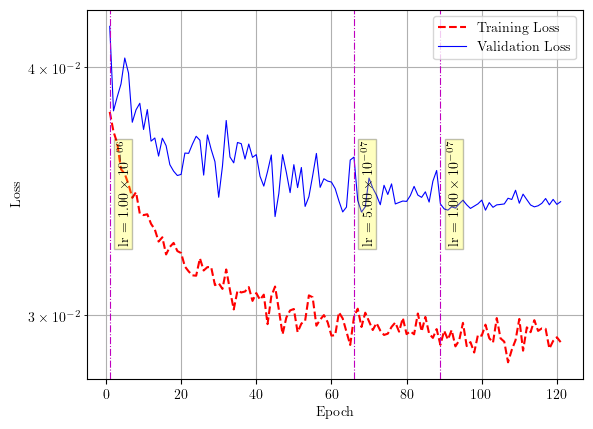

<Figure size 640x480 with 0 Axes>

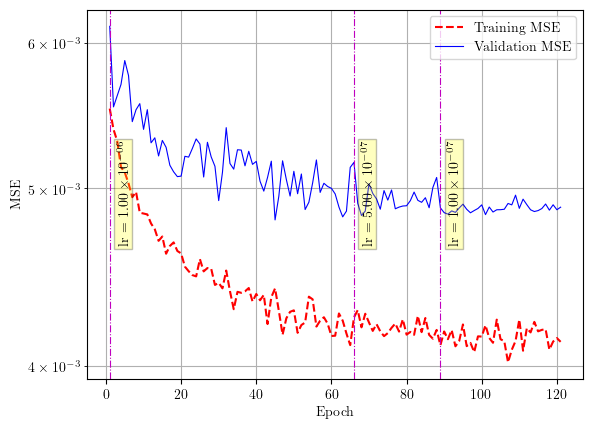

<Figure size 640x480 with 0 Axes>

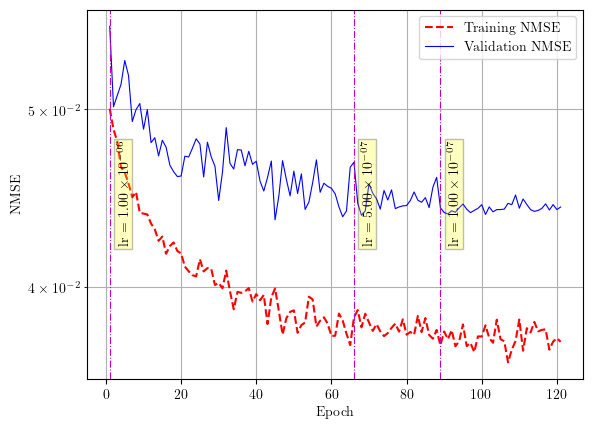

<Figure size 640x480 with 0 Axes>

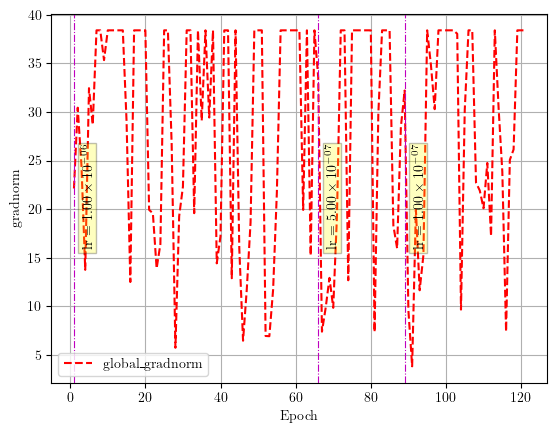

<Figure size 640x480 with 0 Axes>

In [19]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []
            
    if type(batch_size) == type([]):
        if kk > len(batch_size) - 1:
            batch_size_thisoutstep = batch_size[-1]
        else:
            batch_size_thisoutstep = batch_size[kk]
    else:
        batch_size_thisoutstep = batch_size

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size_thisoutstep,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

#     grad_norm_decay = 0.95
#     idxs_to_ignore = 0

#     global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
#     # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
#     global_clipnorm = grad_norm_decay * global_clipnorm
    idxs_to_ignore = 1
    global_clipnorm_min = 3.0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)
    global_clipnorm = max(global_clipnorm, global_clipnorm_min)

In [20]:
a = 123e-5
a

0.00123

In [21]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [22]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [23]:
### Training the combined AE-RNN


# 